## 1. Retrieving EAGLE Galaxy properties

In [1]:
#imports
import eagleSqlTools as sql
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [2]:
#define our EAGLE username/password then connect 
username = 'gqh823'
password = 'ws218shd'

con = sql.connect(username, password=password)

In [3]:
#define the search query 
query="""SELECT MassType_Star as stellar_mass,
StarFormationRate as SFR, 
Redshift, GalaxyID, TopLeafID, LastProgID 
FROM RefL0100N1504_SubHalo
WHERE SnapNum = 28"""

In [4]:
#execute the query
data = sql.execute_query(con,query)

In [5]:
#define the output parameters
sfr = data['SFR']
stellar_mass = data['stellar_mass']

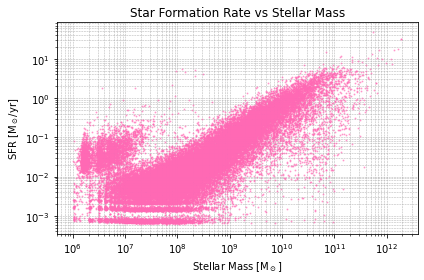

In [21]:
# Make the plot
plt.figure(figsize=(10, 6), dpi=150)

plt.scatter(stellar_mass, sfr, s=1, alpha=0.5, color = 'hotpink', zorder=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass [M$_\\odot$]')
plt.ylabel('SFR [M$_\\odot$/yr]')
plt.title('Star Formation Rate vs Stellar Mass')
plt.grid(True, which="both", ls='--', lw=0.5, zorder=1)
plt.tight_layout()

plt.savefig("Eagle_sfr_vs_stellarmass.pdf")  # Saves as PDF

plt.show()

In [7]:
print(min(stellar_mass), max(stellar_mass))

0.0 1905425300000.0


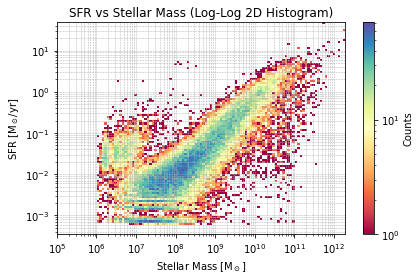

In [22]:
# Clean data: remove zeros

mask = (stellar_mass > 0) & (sfr > 0)
stellar_mass_clean = stellar_mass[mask]
sfr_clean = sfr[mask]

# Set up logarithmic bins
x_bins = np.logspace(np.log10(stellar_mass_clean.min()), np.log10(stellar_mass_clean.max()), 100)
y_bins = np.logspace(np.log10(sfr_clean.min()), np.log10(sfr_clean.max()), 100)

# Plot
plt.figure(figsize=(10, 6), dpi=150)

plt.hist2d(stellar_mass_clean, sfr_clean, bins=[x_bins, y_bins], norm=LogNorm(), cmap='Spectral')
plt.xscale('log')
plt.yscale('log')

plt.ylim(0.00035,)
plt.xlim(1e5,)

plt.xlabel('Stellar Mass [M$_\\odot$]')
plt.ylabel('SFR [M$_\\odot$/yr]')
plt.title('SFR vs Stellar Mass (Log-Log 2D Histogram)')
plt.colorbar(label='Counts')
plt.grid(True, which="both", ls='--', lw=0.5)
plt.tight_layout()

plt.savefig("Eagle_2d_histogram.pdf")  # Saves as PDF

plt.show()


### Stretch Goal

In [11]:
# add colours to the query
colour_query = """
SELECT
  SH.MassType_Star AS stellar_mass,
  SH.StarFormationRate AS SFR,
  (MAG.g_nodust - MAG.r_nodust) AS g_minus_r,
  MAG.r_nodust AS r_band
FROM
  RefL0100N1504_SubHalo AS SH,
  RefL0100N1504_Magnitudes AS MAG
WHERE
  SH.SnapNum = 28 AND
  SH.GalaxyID = MAG.GalaxyID
"""

colour_data = sql.execute_query(con, colour_query)

In [12]:
#define useful properties
coloured_sfr = colour_data['SFR']
coloured_stellar_mass = colour_data['stellar_mass']

In [13]:
print(min(colour_data['g_minus_r']), max(colour_data['g_minus_r']))

-0.210783 1.0170784


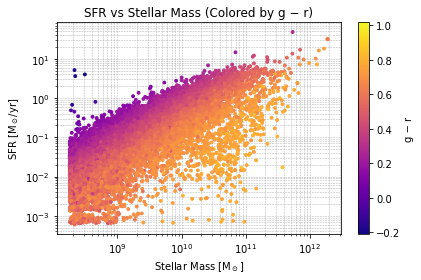

In [23]:
#plot the coloured plot
plt.figure(figsize=(10, 6), dpi=150)

sc = plt.scatter(colour_data['stellar_mass'], colour_data['SFR'], c = colour_data['g_minus_r'], cmap='plasma', s=8, zorder=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass [M$_\\odot$]')
plt.ylabel('SFR [M$_\\odot$/yr]')
plt.title('SFR vs Stellar Mass (Colored by g − r)')
plt.colorbar(sc, label='g − r')
plt.grid(True, which="both", ls='--', lw=0.5, zorder=1)
plt.tight_layout()

plt.savefig("Eagle_coloured_sfr_vs_stellarmass.pdf")  # Saves as PDF

plt.show()


## 2. More redshifts

In [15]:
# new query for a range of redshifts
z_query = """
SELECT MassType_Star AS stellar_mass,
       StarFormationRate AS SFR
FROM RefL0100N1504_SubHalo
WHERE Redshift >= 0 AND Redshift < 0.5
"""
z_data = sql.execute_query(con, z_query)


In [16]:
#define the important properties
z_sfr = z_data['SFR']
z_stellar_mass = z_data['stellar_mass']

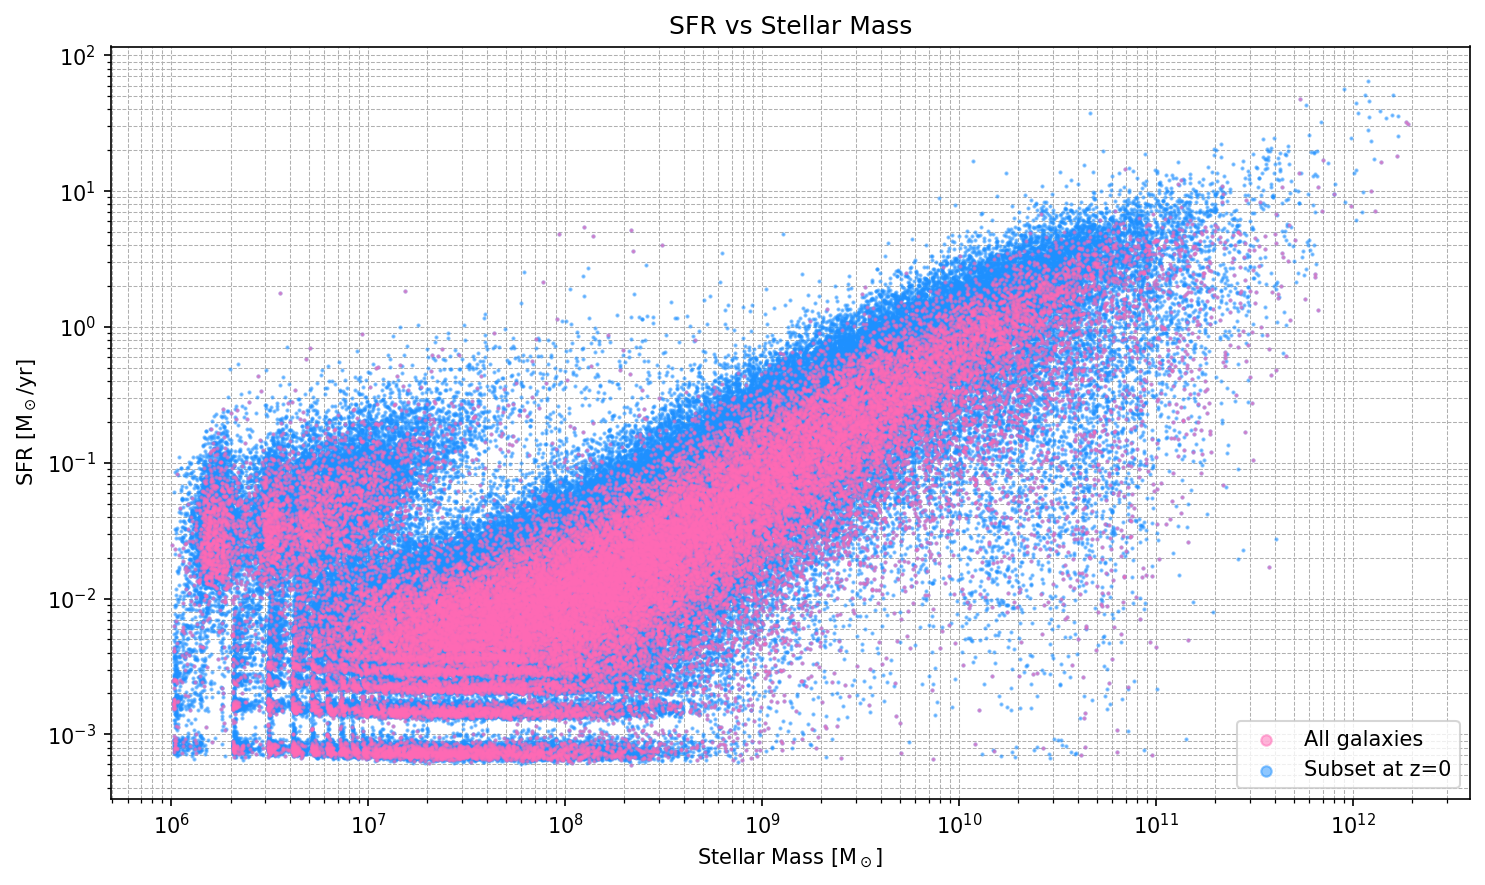

In [25]:
#plot the old and new distributions
plt.figure(figsize=(10, 6), dpi=150)

plt.scatter(stellar_mass, sfr, s=1, alpha=0.5, color='hotpink', label='All galaxies', zorder=3)
plt.scatter(z_stellar_mass, z_sfr, s=1, alpha=0.5, color='dodgerblue', label='Subset at z=0', zorder=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass [M$_\\odot$]')
plt.ylabel('SFR [M$_\\odot$/yr]')
plt.title('SFR vs Stellar Mass')
plt.grid(True, which="both", ls='--', lw=0.5, zorder=1)
plt.legend(loc='lower right', markerscale=5, fontsize=10)

plt.tight_layout()
plt.show()


In [27]:
print(len(z_sfr) , len(sfr))

11819412 2275510


### Stretch Goal

In [19]:
# Find the index where stellar_mass is maximum
max_idx = np.where(stellar_mass == stellar_mass.max())[0][0]

# Access the most massive galaxy's data
top_gal = data[max_idx]

In [20]:
# define the top galaxy's important propetires 
top_gal_mass = top_gal['stellar_mass']
top_leaf = top_gal['TopLeafID']
last_prog = top_gal['LastProgID']
gal_id = top_gal['GalaxyID']

In [21]:
print(f"The galaxy with the largest mass at redshift z=0 is: \n galaxy id: {gal_id} \n mass: {top_gal_mass}")

The galaxy with the largest mass at redshift z=0 is: 
 galaxy id: 21379521 
 mass: 1905425252352.0


In [22]:
#Do a new query between gal id and last prog to get the total descedants 
query_descendants = f"""
SELECT GalaxyID, Redshift, MassType_Star AS stellar_mass, StarFormationRate AS SFR, DescendantID
FROM RefL0100N1504_SubHalo
WHERE GalaxyID BETWEEN {gal_id} AND {last_prog}
ORDER BY SnapNum ASC
"""
descendants = sql.execute_query(con, query_descendants)

In [23]:
print(f"There are {len(descendants)} total descendant galaxies.")

There are 194065 total descendant galaxies.


In [24]:
#make a map to go through to find the main branch descendants
id_map = {row['GalaxyID']: row for row in descendants}
main_branch = []
current_id = int(top_leaf)

#find main branch descendants
while current_id in id_map:
    row = id_map[current_id]
    main_branch.append(row)
    next_id = row['DescendantID']
    if next_id == -1 or next_id == current_id :
        break
    current_id = next_id
    
if main_branch[-1]['GalaxyID'] == main_branch[-1]['DescendantID']:
    main_branch = main_branch[:-1]


main_branch = np.array(main_branch)


In [25]:
print(f"There are {len(main_branch)} descendant galaxies on the main branch.")

There are 27 descendant galaxies on the main branch.


## 3. Querying data from IllustrisTNG

In [50]:
#load in Alicia's data <3
illustris_data = np.load('/mnt/raid-cita/savelli/MWAs/Illustris/data_all.npy', allow_pickle=True)

In [51]:
illustris_data.keys()

dict_keys(['id', 'sfr', 'mass_stars', 'mass_gas', 'mass', 'stellarphotometrics_r', 'stellarphotometrics_g'])

In [52]:
#define important propeties
i_stellar_mass = illustris_data['mass_stars']
i_sfr = illustris_data['sfr']

In [61]:
# check number of galaxies 
print(len(i_sfr))

53939


In [54]:
#convert the weird units used in illustris for comparison to eagle
i_stellar_mass = i_stellar_mass * 10**10 * 0.704

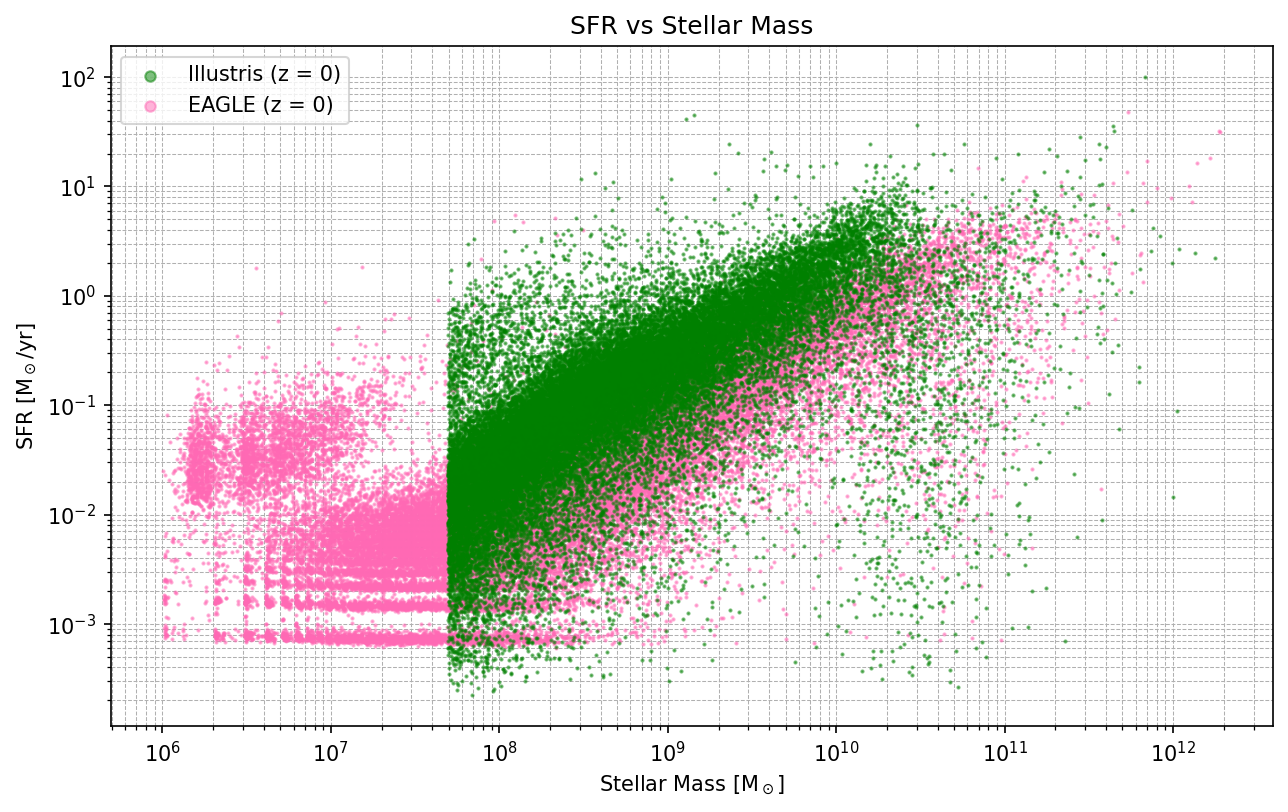

In [60]:
# Make the plot and compare to the other simulations
plt.figure(figsize=(10, 6), dpi=150)
plt.scatter(i_stellar_mass, i_sfr, s=1, alpha=0.5, color='green', zorder=4, label='Illustris (z = 0)')
plt.scatter(stellar_mass, sfr, s=1, alpha=0.5, color='hotpink', zorder=3, label='EAGLE (z = 0)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass [M$_\\odot$]')
plt.ylabel('SFR [M$_\\odot$/yr]')
plt.title('SFR vs Stellar Mass')
plt.grid(True, which="both", ls='--', lw=0.5, zorder=1)
plt.legend(loc='upper left', markerscale=5, fontsize=10)

plt.savefig("Illustris__comparison.pdf")  # Saves as PDF
plt.show()



## 4. Isolating Milky Way-like galaxies in the galaxy color-magnitude diagram

### Eagle Milky Way-like galaxies

In [50]:
mass_limit = 1e9

mass_query = f"""
SELECT
  SH.MassType_Star AS stellar_mass, SH.StarFormationRate AS SFR,
  (MAG.g_nodust - MAG.r_nodust) AS g_minus_r, MAG.g_nodust AS g_band
FROM
  RefL0100N1504_SubHalo AS SH, RefL0100N1504_Magnitudes AS MAG
WHERE
  SH.SnapNum = 28 AND SH.GalaxyID = MAG.GalaxyID AND MassType_Star > {mass_limit}
"""

In [51]:
eagle_mw = sql.execute_query(con, mass_query)

In [52]:
MW_mass_central = 6.08e10
MW_mass_err = 1.14e10
MW_sfr_central = 1.65
MW_sfr_err = 0.19

mass_lo = MW_mass_central - 3 * MW_mass_err
mass_hi = MW_mass_central + 3 * MW_mass_err
sfr_lo = MW_sfr_central - 3 * MW_sfr_err
sfr_hi = MW_sfr_central + 3 * MW_sfr_err

# Filter
MW_analogs = eagle_mw[(eagle_mw['stellar_mass'] > mass_lo) & (eagle_mw['stellar_mass'] < mass_hi) 
    & (eagle_mw['SFR'] > sfr_lo) & (eagle_mw['SFR'] < sfr_hi)]


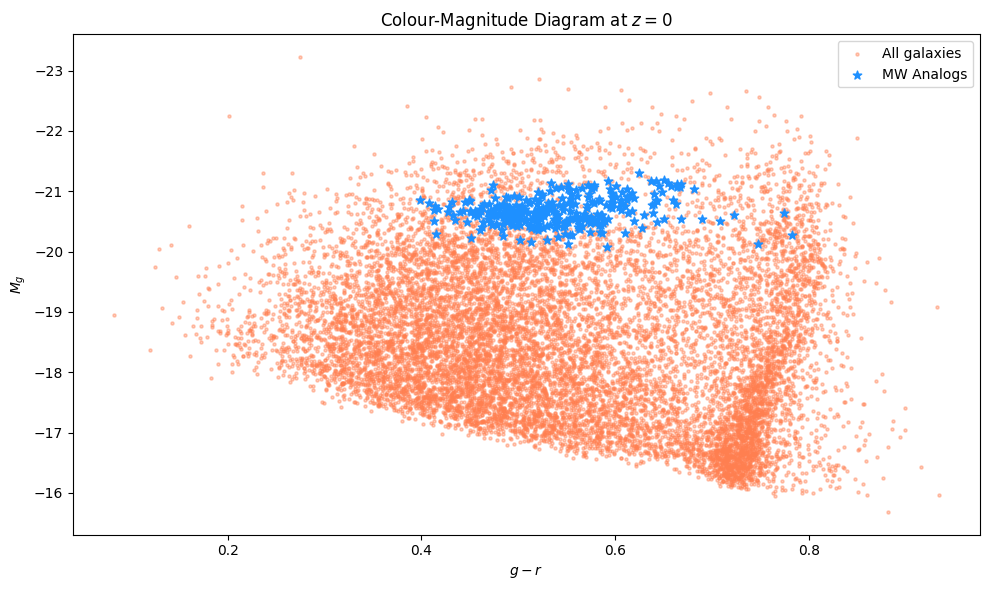

In [57]:
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(eagle_mw['g_minus_r'], eagle_mw['g_band'], s=5, c='coral', alpha=0.4, label='All galaxies')
plt.scatter(MW_analogs['g_minus_r'], MW_analogs['g_band'], s=40, c='dodgerblue',label='MW Analogs', marker='*')

plt.gca().invert_yaxis()
plt.xlabel(r'$g - r$')
plt.ylabel(r'$M_g$')
plt.title('Colour-Magnitude Diagram at $z=0$')
plt.legend()
plt.tight_layout()
plt.show()


### Illustris Milky Way-Like galaxies

In [74]:
import pandas as pd

illustris_data = pd.DataFrame(illustris_data)
illustris_data

,id,sfr,mass_stars,mass_gas,mass,stellarphotometrics_r,stellarphotometrics_g
0,0,2.227190,251.016000,3900.60000,27477.900000,-25.7158,-24.9662
1,1,0.413285,37.852600,444.55900,3666.620000,-23.6833,-22.9476
2,2,17.392200,42.482400,12.61160,773.456000,-24.0692,-23.4980
3,3,5.079380,11.620900,16.96820,339.133000,-22.9552,-22.4122
4,4,1.414690,9.032480,9.43925,325.367000,-22.1905,-21.5482
...,...,...,...,...,...,...,...
53934,1557330,0.000000,0.011428,0.00000,0.011428,-15.3797,-14.7019
53935,1565315,0.000000,0.007074,0.00000,0.007074,-14.8564,-14.1756
53936,1619869,0.000000,0.011053,0.00000,0.011053,-14.7993,-14.0165
53937,1685133,0.000000,0.007796,0.00000,0.007796,-14.9574,-14.2654


In [79]:
# Convert mass to solar masses
stellar_mass_solar = illustris_data['mass_stars'] * 1e10 * 0.704

illustris_data['mass_stars_solar'] = stellar_mass_solar

# Apply cut
illustris_mw = illustris_data[stellar_mass_solar > mass_limit]

i_MW_analogs = illustris_mw[
    (illustris_mw['mass_stars_solar'] > mass_lo) & (illustris_mw['mass_stars_solar'] < mass_hi) &
    (illustris_mw['sfr'] > sfr_lo) & (illustris_mw['sfr'] < sfr_hi)
]


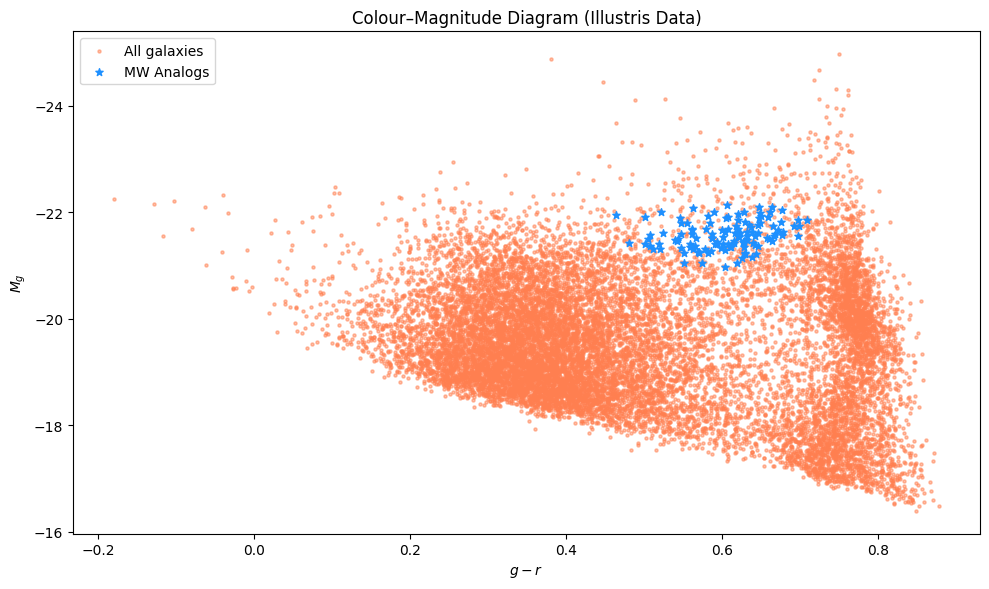

In [84]:
g_mag = illustris_mw['stellarphotometrics_g']
r_mag = illustris_mw['stellarphotometrics_r']
g_minus_r = g_mag - r_mag

g_mag_MW = i_MW_analogs['stellarphotometrics_g']
r_mag_MW = i_MW_analogs['stellarphotometrics_r']
g_minus_r_MW = g_mag_MW - r_mag_MW

plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(g_minus_r, g_mag, s=5, c='coral', label='All galaxies', alpha=0.5)
plt.scatter(g_minus_r_MW, g_mag_MW, s=30, c='dodgerblue', label='MW Analogs', marker='*')

plt.gca().invert_yaxis()
plt.xlabel(r'$g - r$')
plt.ylabel(r'$M_g$')
plt.title('Colour–Magnitude Diagram (Illustris Data)')
plt.legend()
plt.tight_layout()
plt.show()
